In [1]:
from sympy import *
init_printing()

Vmr, Ir, wr = symbols('V_MR I_R \omega_R')
R, KE = symbols('R K_E')
eq1 = Eq(Vmr, R*Ir + KE*wr)

print('モーターの回路方程式')
eq1


モーターの回路方程式


In [2]:
tau_r = symbols('tau_R')
KT = symbols('K_T')

eq2 = Eq(tau_r, KT*Ir)
print('トルク')
eq2

トルク


In [3]:
solve(eq1, (wr))

In [4]:
from sympy import var

Ldy, Ldz = var('\dot{L}_y \dot{L}_z')
g, x, y, z = var('g x y z')
xZ, yZ, zZ = var('x_Z y_Z z_Z')
xdd, ydd, zdd = var('\ddot{x} \ddot{y} \ddot{z} ')

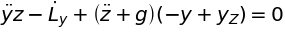

In [10]:
from sympy import solve
from IPython.display import display

E1 = Eq(z * xdd + (xZ - x) * (g + zdd))
E2 = Eq(z * ydd + (yZ - y) * (g + zdd) - Ldy)
E3 = Eq(-y * xdd + x * ydd - zZ * (g + zdd) + Ldz)
display(E1)
display(E2)
display(E3)

sols = solve([E1, E2, E3], [xdd, ydd, Ldy])



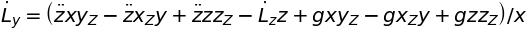

In [6]:
display(Eq(xdd,sols[xdd]))
display(Eq(ydd,sols[ydd]))
display(Eq(Ldy,sols[Ldy]))
